# YOLOv5 vs. ViT-Guided Image Enhancement: A Full Pipeline Comparison on ExDark
This notebook walks through a complete workflow comparing standard YOLOv5 performance with a ViT-based attention-guided enhancement approach. It includes ExDark dataset download, annotation parsing, baseline YOLOv5 training/testing, ViT attention extraction, image enhancement, retraining YOLOv5 on enhanced images, and visualizing performance differences across training loss, validation metrics, and test accuracy.

###Downloading Required Libraries

In [1]:
#Dowloading libraries
!nvidia-smi
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt
from pathlib import Path
import io, zipfile, shutil, random, re, os
from urllib.request import urlopen, Request
from PIL import Image
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import glob, cv2, torch, numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from transformers import ViTImageProcessor, ViTModel

Thu Dec 11 00:32:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   31C    P0             54W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

###Creating Project and Data Paths

In [2]:
Root_Folder = "/content/" #Project root folder
Project_Path = Path(Root_Folder)
Data_Path = Project_Path / "Data" #Data path
GroundTruth_Path  = Project_Path / "GroundTruth" #Annotation path
ZIP_Path = Data_Path / "exdark.zip" #ExDark images ZIP file path
GroundTruth_ZIP = GroundTruth_Path / "ExDark_Groundtruth.zip" #Annotations ZIP path
Images_Path = Project_Path / "Data" / "ExDark" #Extracted images path
GroundTruthAnnotation_Path = Project_Path / "GroundTruth" / "ExDark_Annno" #Extracted annotations path
Output = Project_Path / "Output" #Output path
Output_Masked = Project_Path / "Output_Masked" #Masked output path

#Create directories if they don't exist
Data_Path.mkdir(parents=True, exist_ok=True)
GroundTruth_Path.mkdir(parents=True, exist_ok=True)

print("Project root:", Project_Path)
print("Data dir:", Data_Path)
print("GroundTruth dir:", GroundTruth_Path)

Project root: /content
Data dir: /content/Data
GroundTruth dir: /content/GroundTruth


###Downloading Datasets and Annotations

In [3]:
#Downloading ExDark dataset in Colab if it is not already extracted
if not (Data_Path / "ExDark").exists():

  #Install gdown for downloading from Google Drive
  !pip install -q gdown

  file_id = "1BHmPgu8EsHoFDDkMGLVoXIlCth2dW6Yx"
  gdrive_url = f"https://drive.google.com/uc?id={file_id}"

  print("Downloading ExDARK dataset ...")
  #Download ZIP to the specified path
  !gdown --fuzzy {gdrive_url} -O {ZIP_Path}

  #Verify the ZIP file exists
  if not ZIP_Path.exists():
      raise FileNotFoundError(f"Download failed! File not found at {ZIP_Path}")

  print("Extracting files...")
  #Extract ZIP contents into the Data folder
  with zipfile.ZipFile(ZIP_Path, 'r') as zip_ref:
      zip_ref.extractall(Data_Path)

  print("Extraction complete!")

  #Delete ZIP file after extraction
  ZIP_Path.unlink()

  print("Done! ExDARK extracted to:", Data_Path)
else:
  #Skip if dataset folder already exists
  print("ExDARK already present, skipping download.")

Downloading...
From (original): https://drive.google.com/uc?id=1BHmPgu8EsHoFDDkMGLVoXIlCth2dW6Yx
From (redirected): https://drive.google.com/uc?id=1BHmPgu8EsHoFDDkMGLVoXIlCth2dW6Yx&confirm=t&uuid=a49db4ef-f05b-493f-8811-b754aefb8afe
To: /content/Data/exdark.zip
100% 1.49G/1.49G [00:17<00:00, 83.3MB/s]
Extracting files...
Extraction complete!
Done! ExDARK extracted to: /content/Data


In [4]:
#Download ExDark groundtruth annotations if not already extracted
if not (GroundTruth_Path / "ExDark_Annno").exists():

  #Install gdown for downloading from Google Drive
  !pip install -q gdown

  file_id = "1P3iO3UYn7KoBi5jiUkogJq96N6maZS1i"

  print("Downloading ExDARK Groundtruth...")
  #Download annotations ZIP file
  !gdown --id {file_id} -O {GroundTruth_ZIP}

  #Validate that the ZIP file exists
  if not GroundTruth_ZIP.exists():
      raise FileNotFoundError(f"Download failed! File not found at {GroundTruth_ZIP}")
  else:
      print("Download complete:", GroundTruth_ZIP)

  print("Extracting files...")
  #Extract annotation files into the groundtruth folder
  with zipfile.ZipFile(GroundTruth_ZIP, "r") as zip_ref:
      zip_ref.extractall(GroundTruth_Path)

  print("Extraction complete!")
  print("Groundtruth extracted to:", GroundTruth_Path)

  #Remove ZIP file after extraction
  GroundTruth_ZIP.unlink(missing_ok=True)

else:
  #Skip download if annotation folder already exists
  print("ExDARK annotation already present, skipping download.")

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1P3iO3UYn7KoBi5jiUkogJq96N6maZS1i
From (redirected): https://drive.google.com/uc?id=1P3iO3UYn7KoBi5jiUkogJq96N6maZS1i&confirm=t&uuid=e99e8bdd-caf2-4819-9833-2a4c7c4e95df
To: /content/GroundTruth/ExDark_Groundtruth.zip
100% 5.08M/5.08M [00:00<00:00, 57.1MB/s]
Download complete: /content/GroundTruth/ExDark_Groundtruth.zip
Extracting files...
Extraction complete!
Groundtruth extracted to: /content/GroundTruth


In [5]:
#Image file extensions
Images_Format = {".jpg",".jpeg",".png",".bmp"}
Images_Per_Class = {} #Image count per class
Total_Images = 0 #Total images
Classes = [] #List of classes

#Iterate over each subfolder in ExDark dataset
for p in sorted(Images_Path.iterdir()):
    if p.is_dir():
        Classes.append(p.name) #Store class name
        #Count images in this class folder
        n = len([f for f in p.iterdir() if f.suffix.lower() in Images_Format])
        Images_Per_Class[p.name] = n
        Total_Images += n

#Assign integer IDs for each class
Classes_ID = {c:i for i,c in enumerate(Classes)}

print("Classes found under Data/ExDark:", Classes)
print("Total images in Data/ExDark:", Total_Images)
print("Per-class image counts:", Images_Per_Class)

Classes found under Data/ExDark: ['Bicycle', 'Boat', 'Bottle', 'Bus', 'Car', 'Cat', 'Chair', 'Cup', 'Dog', 'Motorbike', 'People', 'Table']
Total images in Data/ExDark: 7363
Per-class image counts: {'Bicycle': 652, 'Boat': 679, 'Bottle': 547, 'Bus': 527, 'Car': 638, 'Cat': 735, 'Chair': 648, 'Cup': 519, 'Dog': 801, 'Motorbike': 503, 'People': 609, 'Table': 505}


In [6]:
#Count annotation files for each class
Annotations_Per_Class = {} #Number of annotation files per class
Total_Annotations = 0 #Total number of annotation files

for c in Classes:
  gdir = GroundTruthAnnotation_Path / c
  if gdir.exists():
    #Count all annotation files
    n = len([f for f in gdir.iterdir() if f.is_file() and f.suffix==".txt"])
    Annotations_Per_Class[c] = n
    Total_Annotations += n
  else:
    #No annotations present for this class
    Annotations_Per_Class[c] = 0

print("GroundTruth root:", GroundTruthAnnotation_Path)
print("Total GT .txt files for listed classes:", Total_Annotations)
print("Per-class GT counts (txt files):", Annotations_Per_Class)

GroundTruth root: /content/GroundTruth/ExDark_Annno
Total GT .txt files for listed classes: 7363
Per-class GT counts (txt files): {'Bicycle': 652, 'Boat': 679, 'Bottle': 547, 'Bus': 527, 'Car': 638, 'Cat': 735, 'Chair': 648, 'Cup': 519, 'Dog': 801, 'Motorbike': 503, 'People': 609, 'Table': 505}


###Parsing ExDark Annotation Files

In [7]:
#Parse a single annotation line from ExDark and convert it to YOLO format
def Exdark_Annotation_Line(Line, W, H, Folder_Class):

  Line = Line.strip()
  if not Line or Line.startswith('%'): # Skip empty/commented lines
    return None

  #Split line by commas or whitespace
  Parts = re.split(r'[,\s]+', Line)
  if len(Parts) < 5: #Must contain at least: class x y w h
    return None

  Class_Name = Parts[0]
  #Convert bounding box values to float
  try:
    x, y, w, h = map(float, Parts[1:5])
  except:
    return None

  #Compute bounding box corners
  xmin, ymin = x, y
  xmax, ymax = x + max(0.0, w), y + max(0.0, h)

  #Clamp coordinates to image dimensions
  xmin = max(0.0, min(float(W), xmin)); ymin = max(0.0, min(float(H), ymin))
  xmax = max(0.0, min(float(W), xmax)); ymax = max(0.0, min(float(H), ymax))

  #Discard invalid or zero area boxes
  if xmax <= xmin or ymax <= ymin:
    return None

  #Convert to YOLO normalized format (cx, cy, w, h)
  cx = ((xmin + xmax)/2.0) / W
  cy = ((ymin + ymax)/2.0) / H
  ww = (xmax - xmin) / W
  hh = (ymax - ymin) / H
  if ww <= 0 or hh <= 0:
    return None

  #Use class name from line
  Class = (Class_Name or Folder_Class).strip()
  return (Class, cx, cy, ww, hh)

#Parse an entire annotation file and return all valid YOLO format boxes
def Exdark_Annotation_File(txt_Path, W, H, Folder_Class):
  Out = []
  with open(txt_Path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
      row = Exdark_Annotation_Line(line, W, H, Folder_Class)
      if row:
        Out.append(row)
  return Out

In [8]:
#Iterate through all images and load their corresponding annotation files

#Stores valid image annotation pairs, missing files count, and bad images count
Records, Missing, Bad = [], 0, 0

for Class in Classes:
  Images_Directory = Images_Path/Class
  GroundTruth_Directory  = GroundTruthAnnotation_Path/Class

  #Skip if no annotation folder exists for this class
  if not GroundTruth_Directory.exists():
    print(f"No groundtruth directory for class '{Class}': {GroundTruth_Directory}")
    continue

  #Iterate over all images in the class folder
  for Img in sorted(Images_Directory.iterdir()):
    if Img.suffix.lower() not in Images_Format: #Skip non-image files
      continue

    #Build annotation file path
    GroundTruth_txt = GroundTruth_Directory / f"{Img.name}.txt"

    #If annotation is missing, count it and continue
    if not GroundTruth_txt.exists():
      Missing += 1
      continue

    #Try loading image to read its dimensions
    try:
      with Image.open(Img) as Im:
        W, H = Im.size
    except Exception:
      Bad += 1 #Image failed to load
      continue

    #Parse the annotation file
    Annotations = Exdark_Annotation_File(GroundTruth_txt, W, H, Folder_Class=Class)
    if Annotations:
      Records.append((Img, Annotations)) #Store tuple: (image_path, annotation_list)

print(f"Annotated Images: {len(Records)}, Missing GroundTruth.txt: {Missing}, Bad Images: {Bad}")

Annotated Images: 7361, Missing GroundTruth.txt: 1, Bad Images: 0


###Creating YOLO Dataset Splits

In [9]:
#Shuffle all (image, annotation) records to randomize dataset ordering
random.shuffle(Records)

#Compute dataset split sizes
N = len(Records)
N_Train = int(0.80*N) #80% training
N_Val = int(0.10*N) #10% validation

#Create train/val/test splits
Splits = {"train": Records[:N_Train], "val": Records[N_Train:N_Train+N_Val], "test": Records[N_Train+N_Val:]}
print({k: len(v) for k,v in Splits.items()}, f"Total: {sum(len(v) for v in Splits.values())}")

{'train': 5888, 'val': 736, 'test': 737} Total: 7361


In [10]:
#Create YOLO formatted image and label folders
for Sp, Items in Splits.items():

  #Create image and label directories for each split (train/val/test)
  (Output/"images"/Sp).mkdir(parents=True, exist_ok=True)
  (Output/"labels"/Sp).mkdir(parents=True, exist_ok=True)

  #Process each (image, annotation) pair in this split
  for (Img, Anns) in Items:

    #Copy image into the YOLO images folder
    Img2 = Output/"images"/Sp/Img.name
    if not Img2.exists():
      shutil.copy2(Img, Img2)
    #Create YOLO label file corresponding to the image
    Lables_Out = Output/"labels"/Sp/(Img.stem + ".txt")
    with open(Lables_Out, "w") as f:
      for (cls, cx, cy, w, h) in Anns:
        f.write(f"{Classes_ID[cls]} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

print("YOLO dataset built at:", Output)

YOLO dataset built at: /content/Output


###Build YAML and Train YOLOv5

In [11]:
#Build the YOLO dataset YAML configuration text
yaml_text = f"""path: {Output}
train: /content/Output/images/train
val: /content/Output/images/val
test: /content/Output/images/test
names:
"""
#Add class index name entries
for i,c in enumerate(Classes):
    yaml_text += f"  {i}: {c}\n"
#Save YAML file to the project directory
yaml_path = Project_Path / "exdark.yaml"
yaml_path.write_text(yaml_text)
print("Wrote", yaml_path)
print(yaml_text)

Wrote /content/exdark.yaml
path: /content/Output
train: /content/Output/images/train
val: /content/Output/images/val
test: /content/Output/images/test
names:
  0: Bicycle
  1: Boat
  2: Bottle
  3: Bus
  4: Car
  5: Cat
  6: Chair
  7: Cup
  8: Dog
  9: Motorbike
  10: People
  11: Table



In [12]:
#Train YOLOv5 on the ExDark dataset
!python train.py \
    --img 640 \
    --batch 16 \
    --epochs 200 \
    --patience 20 \
    --data /content/exdark.yaml \
    --weights yolov5s.pt \
    --device 0 \
    --name exdark_y5s

Streaming output truncated to the last 5000 lines.
    168/199         5G    0.02771    0.02594   0.004396        149        640:  29% 105/368 [00:11<00:39,  6.59it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    168/199         5G    0.02767    0.02585   0.004414         61        640:  29% 106/368 [00:11<00:37,  7.04it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    168/199         5G    0.02763     0.0258     0.0044         83        640:  29% 106/368 [00:11<00:37,  7.04it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    168/199         5G     0.02

###Visualizing YOLOv5 Training and Validation Metrics

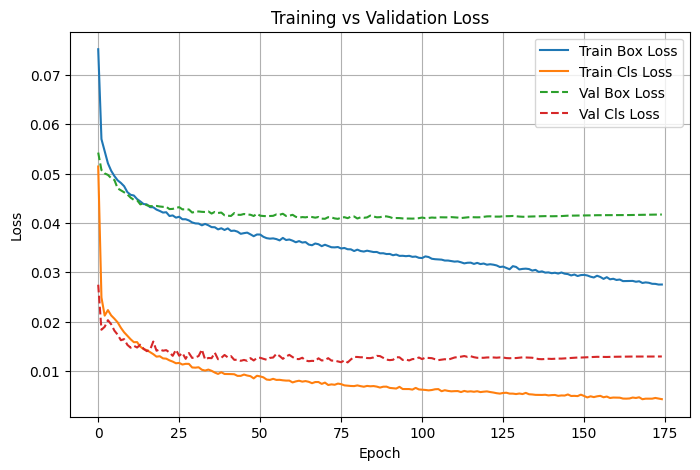

In [13]:
#Load YOLOv5 training results CSV file
df = pd.read_csv("/content/yolov5/runs/train/exdark_y5s/results.csv")
df.columns = df.columns.str.strip()

#Plot Training vs Validation Loss
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Cls Loss")
plt.plot(df["epoch"], df["val/box_loss"], '--', label="Val Box Loss")
plt.plot(df["epoch"], df["val/cls_loss"], '--', label="Val Cls Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

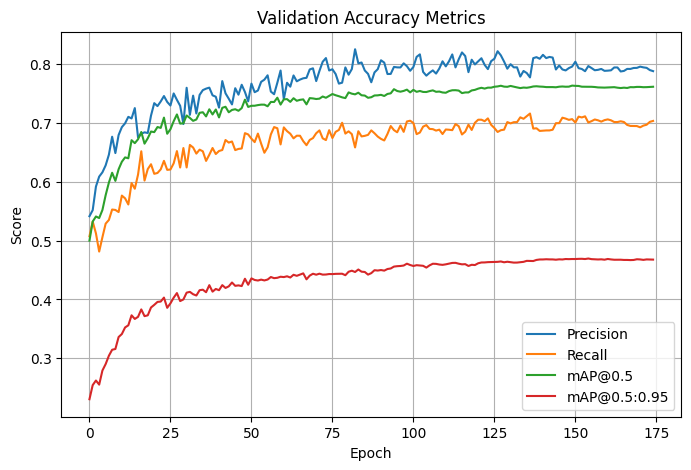

In [15]:
#Plot Validation Accuracy Metrics
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['metrics/precision'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall'], label='Recall')
plt.plot(df['epoch'], df['metrics/mAP_0.5'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Accuracy Metrics')
plt.legend()
plt.grid()
plt.show()

###YOLOv5 Test Evaluation

In [16]:
#Evaluate YOLOv5 on the test split
%cd /content/yolov5
!python val.py \
  --weights /content/yolov5/runs/train/exdark_y5s/weights/best.pt \
  --data /content/exdark.yaml \
  --task test \
  --img 640 \
  --conf-thres 0.001 \
  --iou-thres 0.6 \
  --device 0 \
  --workers 8 \
  --name exdark_y5s_test

/content/yolov5
val: data=/content/exdark.yaml, weights=['/content/yolov5/runs/train/exdark_y5s/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exdark_y5s_test, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-450-g781b9d57 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)

Fusing layers... 
Model summary: 157 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs
test: Scanning /content/Output/labels/test... 737 images, 0 backgrounds, 0 corrupt: 100% 737/737 [00:00<00:00, 3193.11it/s]
test: WARNING ⚠️ /content/Output/images/test/2015_02636.jpg: corrupt JPEG restored and saved
test: WARNING ⚠️ /content/Output/images/test/2015_02640.jpg: corrupt JPEG restored and saved
test: WARNING ⚠️ /content/Output/images/test/2015_04723.jpg: corrupt JPEG restored 

###ViT Attention Extraction & Image Enhancement

In [38]:
#Select GPU if available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device selected: {device}")

#Input dataset and output directories for masks and enhanced images
Input = "/content/Data/ExDark"
Mask_Path = "/content/Data/ExDark_Mask"
Masked_Path = "/content/Data/ExDark_Masked"

#Create output folders if they don't already exist
os.makedirs(Mask_Path, exist_ok=True)
os.makedirs(Masked_Path, exist_ok=True)
print("Mask output folder: ", Mask_Path)
print("Masked images output folder:", Masked_Path)

#Load pretrained Vision Transformer (ViT) for attention extraction
Model_Name = "google/vit-base-patch16-224"
print(f"Loading ViT model: {Model_Name} ...")
Processor = ViTImageProcessor.from_pretrained(Model_Name)
Model = ViTModel.from_pretrained(Model_Name, output_attentions=True).to(device).eval()
print("ViT model loaded and moved to device.")

#Freeze model parameters: No training, only inference
for p in Model.parameters():
  p.requires_grad = False

Device selected: cuda
Mask output folder:  /content/Data/ExDark_Mask
Masked images output folder: /content/Data/ExDark_Masked
Loading ViT model: google/vit-base-patch16-224 ...


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT model loaded and moved to device.


In [39]:
#Compute attention rollout across ViT layers
def AttentionRollout(Attentions):

  #Average attention across heads for each layer
  Attn = [a.mean(dim=1) for a in Attentions]

  #Normalize attention rows so each row sums to 1
  Attn = [a / (a.sum(dim=-1, keepdim=True) + 1e-6) for a in Attn]

  #Rollout which multiply attention matrices from shallow to deep layers
  R = Attn[0]
  for a in Attn[1:]:
    R = a @ R

  #Return CLS-to-patch attention importance
  return R[:, 0, 1:]

In [40]:
#Generate a ViT attention mask and apply it to enhance important regions in the image
def MaskandApply(Img_BGR, Base=0.3, Gain=2.0):

  #Convert input image from BGR to RGB for ViT processing
  Img_BGR = cv2.cvtColor(Img_BGR, cv2.COLOR_BGR2RGB)
  H, W = Img_BGR.shape[:2]

  #Preprocess image for the ViT model
  Inputs = Processor(images=Img_BGR, return_tensors="pt")
  PixelValues = Inputs["pixel_values"].to(device)

  #Forward pass to obtain attention maps
  with torch.no_grad():
    Outpts = Model(PixelValues, output_attentions=True)
    Atts = Outpts.attentions

  #Compute attention rollout across layers
  Roll = AttentionRollout(Atts)
  B, N = Roll.shape

  #Convert token attention to 2D spatial mask (patch16 to 14*14 grid)
  g = int((PixelValues.shape[-1] // 16))
  m = Roll.view(B, 1, g, g)
  m = F.interpolate(m, size=(H, W), mode="bilinear", align_corners=False)[0,0]

  #Normalize mask to [0,1]
  m = (m - m.min()) / (m.max() - m.min() + 1e-6)

  #Slight sharpening to boost high-attention regions
  gamma = 0.7
  m = m.pow(gamma)

  #Generate pixel-wise weight map and enhance the image
  Weight = (Base + Gain * m).cpu().numpy().astype(np.float32)
  Out_RGB = (Img_BGR.astype(np.float32) * Weight[..., None]).clip(0,255).astype(np.uint8)

  #Convert back to BGR
  Out_RGB = cv2.cvtColor(Out_RGB, cv2.COLOR_RGB2BGR)

  #Create mask visualization
  Mask_Vis = (m.cpu().numpy() * 255).astype(np.uint8)
  return Out_RGB, Mask_Vis

In [55]:
#Image extensions
Extensions = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.JPG", "*.JPEG", "*.PNG", "*.BMP")
All_Imgs = []

#Collect all images
for e in Extensions:
  All_Imgs += glob.glob(os.path.join(Input, "**", e), recursive=True)

print(f"Found {len(All_Imgs)} images under {Input}")

print("Starting attention mask generation and enhancement...\n")
#Process each image and generate its mask and enhanced version
for pin in tqdm(All_Imgs):

  #Image path
  Rel = os.path.relpath(pin, Input)

  #Output paths for mask and masked image
  Otpt_Mask = os.path.join(Mask_Path, Rel)
  Otpt_Masked = os.path.join(Masked_Path, Rel)

  #Ensure output directories exist
  os.makedirs(os.path.dirname(Otpt_Mask), exist_ok=True)
  os.makedirs(os.path.dirname(Otpt_Masked), exist_ok=True)

  #Read the input image
  Img = cv2.imread(pin)
  if Img is None:
    print("Cannot read", pin)
    continue

  try:
    #Apply ViT attention mask and enhancement
    Masked, Mask = MaskandApply(Img)

    #Save the grayscale mask
    Mask_Out = Otpt_Mask
    cv2.imwrite(Mask_Out, Mask)


    #Save the enhanced image
    Masked_Out = Otpt_Masked
    cv2.imwrite(Masked_Out, Masked)

  except Exception as e:
    print("ERROR on", pin, ":", e)

print("\nCompleted generating masks and enhanced images.")
print("Masks saved to:", Mask_Path)
print("Enhanced images saved to:", Masked_Path)

Found 7363 images under /content/Data/ExDark
Starting attention mask generation and enhancement...



100%|██████████| 7363/7363 [05:56<00:00, 20.64it/s]


Completed generating masks and enhanced images.
Masks saved to: /content/Data/ExDark_Mask
Enhanced images saved to: /content/Data/ExDark_Masked


###Parsing Annotations and Creating YOLO Training Splits for Enhanced Images

In [56]:
Records, Missing, Bad = [], 0, 0

Images_Path = Project_Path / "Data" / "ExDark_Masked"
for Class in Classes:
  Images_Directory = Images_Path/Class
  GroundTruth_Directory  = GroundTruthAnnotation_Path/Class

  if not GroundTruth_Directory.exists():
    print(f"No groundtruth directory for class '{Class}': {GroundTruth_Directory}")
    continue

  for Img in sorted(Images_Directory.iterdir()):
    if Img.suffix.lower() not in Images_Format:
      continue

    GroundTruth_txt = GroundTruth_Directory / f"{Img.name}.txt"

    if not GroundTruth_txt.exists():
      Missing += 1
      continue

    try:
      with Image.open(Img) as Im:
        W, H = Im.size
    except Exception:
      Bad += 1
      continue

    Annotations = Exdark_Annotation_File(GroundTruth_txt, W, H, Folder_Class=Class)
    if Annotations:
      Records.append((Img, Annotations))

print(f"Annotated Images: {len(Records)}, Missing GroundTruth.txt: {Missing}, Bad Images: {Bad}")

Annotated Images: 7361, Missing GroundTruth.txt: 1, Bad Images: 0


In [57]:
#Shuffle all (image, annotation) records to randomize dataset ordering
random.shuffle(Records)

#Compute dataset split sizes
N = len(Records)
N_Train = int(0.80*N) #80% training
N_Val = int(0.10*N) #10% validation

#Create train/val/test splits
Splits = {"train": Records[:N_Train], "val": Records[N_Train:N_Train+N_Val], "test": Records[N_Train+N_Val:]}
print({k: len(v) for k,v in Splits.items()}, f"Total: {sum(len(v) for v in Splits.values())}")

{'train': 5888, 'val': 736, 'test': 737} Total: 7361


In [58]:
#Create YOLO formatted image and label folders
for Sp, Items in Splits.items():

  #Create image and label directories for each split (train/val/test)
  (Output_Masked/"images"/Sp).mkdir(parents=True, exist_ok=True)
  (Output_Masked/"labels"/Sp).mkdir(parents=True, exist_ok=True)

  #Process each (image, annotation) pair in this split
  for (Img, Anns) in Items:

    #Copy image into the YOLO images folder
    Img2 = Output_Masked/"images"/Sp/Img.name
    if not Img2.exists():
      shutil.copy2(Img, Img2)
    #Create YOLO label file corresponding to the image
    Lables_Out = Output_Masked/"labels"/Sp/(Img.stem + ".txt")
    with open(Lables_Out, "w") as f:
      for (cls, cx, cy, w, h) in Anns:
        f.write(f"{Classes_ID[cls]} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

print("YOLO dataset built at:", Output_Masked)

YOLO dataset built at: /content/Output_Masked


###Build YAML and Train ViT-YOLOv5

In [59]:
#Build the YOLO dataset YAML configuration text
yaml_text = f"""path: {Output_Masked}
train: /content/Output_Masked/images/train
val: /content/Output_Masked/images/val
test: /content/Output_Masked/images/test
names:
"""
#Add class index name entries
for i,c in enumerate(Classes):
    yaml_text += f"  {i}: {c}\n"
#Save YAML file to the project directory
yaml_path = Project_Path / "exdark2.yaml"
yaml_path.write_text(yaml_text)
print("Wrote", yaml_path)
print(yaml_text)

Wrote /content/exdark2.yaml
path: /content/Output_Masked
train: /content/Output_Masked/images/train
val: /content/Output_Masked/images/val
test: /content/Output_Masked/images/test
names:
  0: Bicycle
  1: Boat
  2: Bottle
  3: Bus
  4: Car
  5: Cat
  6: Chair
  7: Cup
  8: Dog
  9: Motorbike
  10: People
  11: Table



In [60]:
#Train YOLOv5 on the enhanced images
!python train.py \
    --img 640 \
    --batch 16 \
    --epochs 200 \
    --patience 20 \
    --data /content/exdark2.yaml \
    --weights yolov5s.pt \
    --device 0 \
    --name exdark_y5s_es2

Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
    194/199      4.96G    0.02714    0.02519   0.003928         98        640:  40% 177/442 [00:17<00:25, 10.35it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    194/199      4.96G    0.02713    0.02522   0.003925        121        640:  40% 179/442 [00:17<00:24, 10.65it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    194/199      4.96G    0.02711    0.02519   0.003927         74        640:  40% 179/442 [00:17<00:24, 10.65it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(

###Comparing Baseline and Proposed Method Training and Validation Metrics

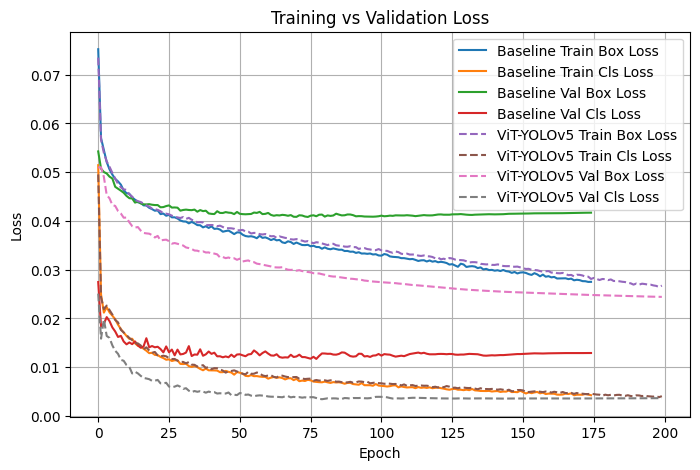

In [61]:
#Load ViT-YOLOv5 training results CSV file
df2 = pd.read_csv("/content/yolov5/runs/train/exdark_y5s_es22/results.csv")
df2.columns = df2.columns.str.strip()

#Plot Training vs Validation Loss
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["train/box_loss"], label="Baseline Train Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Baseline Train Cls Loss")
plt.plot(df["epoch"], df["val/box_loss"], label="Baseline Val Box Loss")
plt.plot(df["epoch"], df["val/cls_loss"], label="Baseline Val Cls Loss")
plt.plot(df2["epoch"], df2["train/box_loss"], '--', label="ViT-YOLOv5 Train Box Loss")
plt.plot(df2["epoch"], df2["train/cls_loss"], '--', label="ViT-YOLOv5 Train Cls Loss")
plt.plot(df2["epoch"], df2["val/box_loss"], '--', label="ViT-YOLOv5 Val Box Loss")
plt.plot(df2["epoch"], df2["val/cls_loss"], '--', label="ViT-YOLOv5 Val Cls Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

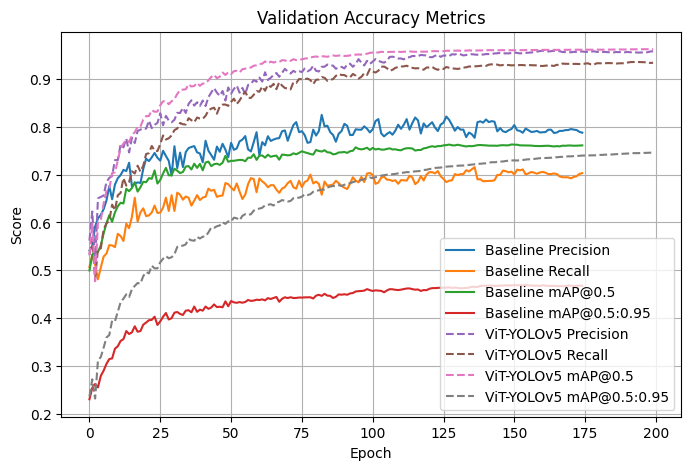

In [62]:
#Plot Validation Accuracy Metrics
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['metrics/precision'], label='Baseline Precision')
plt.plot(df['epoch'], df['metrics/recall'], label='Baseline Recall')
plt.plot(df['epoch'], df['metrics/mAP_0.5'], label='Baseline mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP_0.5:0.95'], label='Baseline mAP@0.5:0.95')
plt.plot(df2['epoch'], df2['metrics/precision'], '--', label='ViT-YOLOv5 Precision')
plt.plot(df2['epoch'], df2['metrics/recall'], '--', label='ViT-YOLOv5 Recall')
plt.plot(df2['epoch'], df2['metrics/mAP_0.5'], '--', label='ViT-YOLOv5 mAP@0.5')
plt.plot(df2['epoch'], df2['metrics/mAP_0.5:0.95'], '--', label='ViT-YOLOv5 mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Accuracy Metrics')
plt.legend()
plt.grid()
plt.show()

###ViT-YOLOv5 Test Evaluation

In [63]:
#Evaluate ViT-YOLOv5 on the test split
%cd /content/yolov5
!python val.py \
  --weights /content/yolov5/runs/train/exdark_y5s_es22/weights/best.pt \
  --data /content/exdark2.yaml \
  --task test \
  --img 640 \
  --conf-thres 0.001 \
  --iou-thres 0.6 \
  --device 0 \
  --workers 8 \
  --name exdark_y5s_es2_test

/content/yolov5
val: data=/content/exdark2.yaml, weights=['/content/yolov5/runs/train/exdark_y5s_es22/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exdark_y5s_es2_test, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-450-g781b9d57 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)

Fusing layers... 
Model summary: 157 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs
test: Scanning /content/Output_Masked/labels/test... 1396 images, 0 backgrounds, 0 corrupt: 100% 1396/1396 [00:00<00:00, 10303.17it/s]
test: New cache created: /content/Output_Masked/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 44/44 [00:11<00:00,  3.69it/s]
                   all       1396       4441      0.966 

###Comparing Test Metrics for Baseline YOLOv5 vs ViT-Enhanced YOLOv5

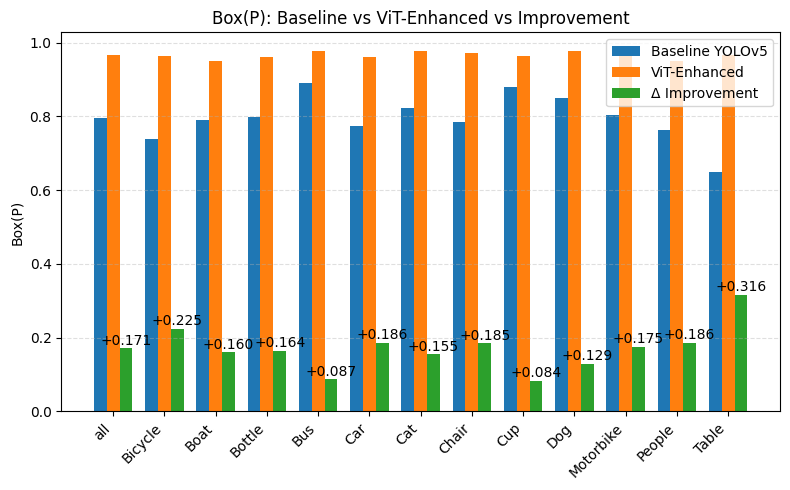

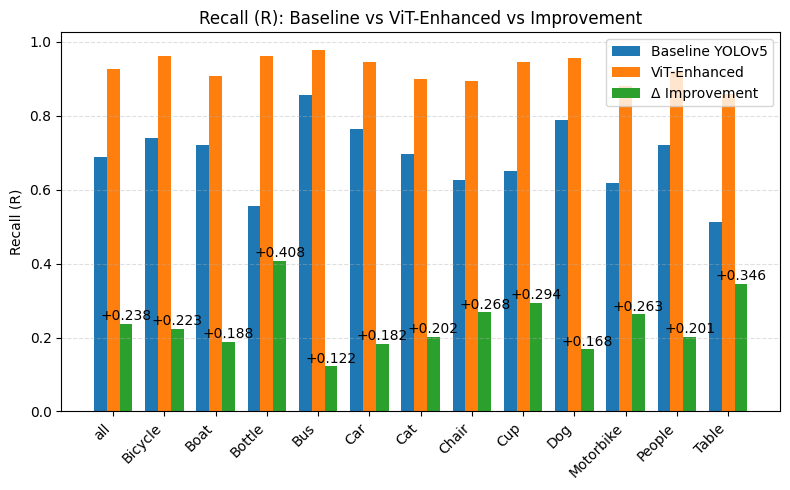

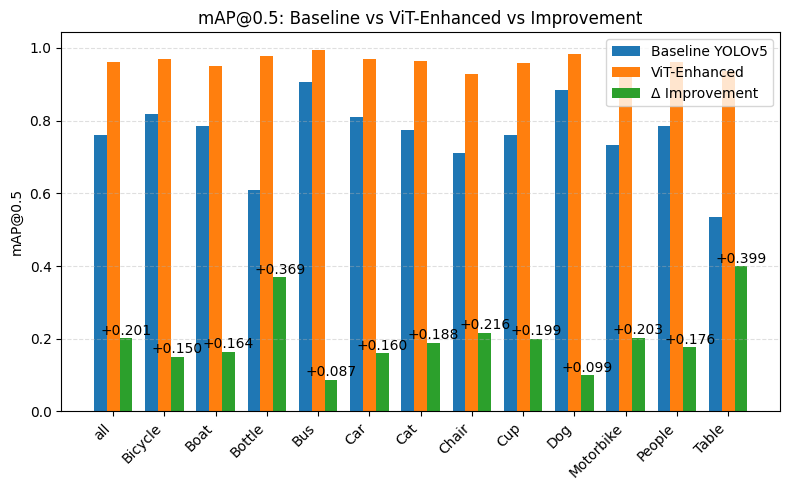

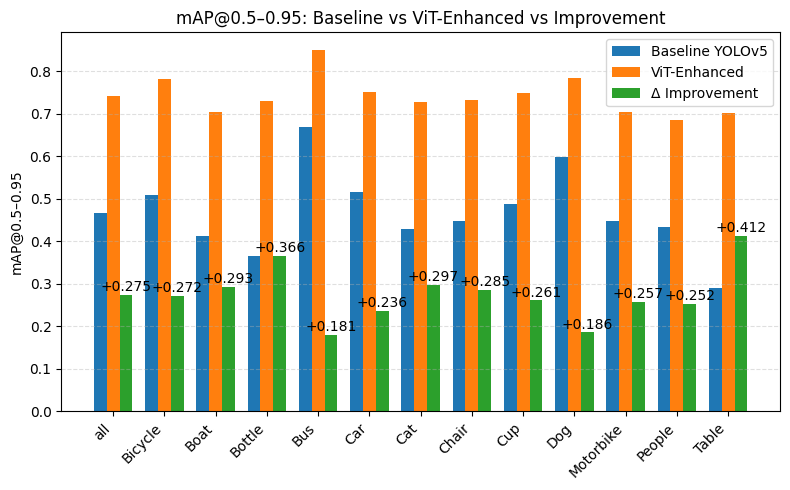

In [66]:
classes = ["all","Bicycle","Boat","Bottle","Bus","Car","Cat",
           "Chair","Cup","Dog","Motorbike","People","Table"]

#Baseline YOLOv5 metrics (copied form testing results)

baseline_boxP = [0.795, 0.740, 0.790, 0.798, 0.890, 0.774,
                 0.822, 0.786, 0.879, 0.849, 0.804, 0.763, 0.650]

baseline_R = [0.688, 0.739, 0.720, 0.555, 0.855, 0.764,
              0.697, 0.627, 0.652, 0.788, 0.619, 0.720, 0.514]

baseline_mAP50 = [0.759, 0.819, 0.786, 0.608, 0.906, 0.809,
                  0.775, 0.712, 0.760, 0.885, 0.734, 0.785, 0.536]

baseline_mAP5095 = [0.467, 0.509, 0.412, 0.365, 0.668, 0.516,
                     0.430, 0.447, 0.487, 0.598, 0.448, 0.433, 0.290]

#ViT-Enhance metrics (copied form testing results)
enh_boxP = [0.966, 0.965, 0.950, 0.962, 0.977, 0.960,
            0.977, 0.971, 0.963, 0.978, 0.979, 0.949, 0.966]

enh_R = [0.926, 0.962, 0.908, 0.963, 0.977, 0.946,
         0.899, 0.895, 0.946, 0.956, 0.882, 0.921, 0.860]

enh_mAP50 = [0.960, 0.969, 0.950, 0.977, 0.993, 0.969,
             0.963, 0.928, 0.959, 0.984, 0.937, 0.961, 0.935]

enh_mAP5095 = [0.742, 0.781, 0.705, 0.731, 0.849, 0.752,
                0.727, 0.732, 0.748, 0.784, 0.705, 0.685, 0.702]

def plot_metric(classes, baseline, enhanced, metric_name):
    baseline = np.array(baseline)
    enhanced = np.array(enhanced)
    improvement = enhanced - baseline

    x = np.arange(len(classes))
    w = 0.25

    plt.figure(figsize=(8,5))

    #Bars: baseline, enhanced, and delta
    plt.bar(x - w, baseline, width=w, label="Baseline YOLOv5")
    plt.bar(x, enhanced, width=w, label="ViT-Enhanced")
    plt.bar(x + w, improvement, width=w, label="Δ Improvement")

    # label delta values
    for i, v in enumerate(improvement):
        plt.text(x[i] + w, v + (0.002 if v >= 0 else -0.01),
                 f"{v:+.3f}", ha="center",
                 va="bottom" if v >= 0 else "top")

    plt.xticks(x, classes, rotation=45, ha="right")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name}: Baseline vs ViT-Enhanced vs Improvement")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

#Plot all four metrics
plot_metric(classes, baseline_boxP, enh_boxP, "Box(P)")
plot_metric(classes, baseline_R,    enh_R,    "Recall (R)")
plot_metric(classes, baseline_mAP50, enh_mAP50, "mAP@0.5")
plot_metric(classes, baseline_mAP5095, enh_mAP5095, "mAP@0.5–0.95")